In [5]:
import tensorflow as tf
from transformers import (
    BertTokenizerFast,
    TFBertForMaskedLM,
    DataCollatorForLanguageModeling,
)
from datasets import load_dataset
import math
from transformers import create_optimizer
model_name = "bert-large-uncased"
dataset_path = "/kaggle/input/sentences/cv-unique-has-end-punct-sentences.csv"
text_column = "sentence"
input_dir = "/kaggle/input/model1"
output_dir = "./mlm_tf"
max_seq_length = 128
batch_size = 8
num_train_epochs = 10
learning_rate = 1e-5
mlm_probability = 0.15

tokenizer = BertTokenizerFast.from_pretrained(output_dir)
model = TFBertForMaskedLM.from_pretrained(output_dir)

dataset = load_dataset("csv", data_files={"data": dataset_path})["data"]
dataset = dataset.shuffle().train_test_split(test_size=0.1)
train_dataset = dataset["train"].select(range(10000))
val_dataset = dataset["test"].select(range(2000))

def tokenize_fn(example):
    return tokenizer(example[text_column], truncation=True, padding="max_length", max_length=max_seq_length)

train_dataset = train_dataset.map(tokenize_fn, batched=True, remove_columns=[text_column])
val_dataset = val_dataset.map(tokenize_fn, batched=True, remove_columns=[text_column])

collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=mlm_probability,
    return_tensors="tf"
)

def convert_dataset_to_tf(ds):
    def gen():
        for batch in ds:
            tokenized = collator([batch])
            yield {
                "input_ids": tokenized["input_ids"][0],
                "attention_mask": tokenized["attention_mask"][0],
                "labels": tokenized["labels"][0],
            }
    return tf.data.Dataset.from_generator(
        gen,
        output_signature={
            "input_ids": tf.TensorSpec(shape=(max_seq_length,), dtype=tf.int32),
            "attention_mask": tf.TensorSpec(shape=(max_seq_length,), dtype=tf.int32),
            "labels": tf.TensorSpec(shape=(max_seq_length,), dtype=tf.int32),
        }
    ).batch(batch_size)

tf_train = convert_dataset_to_tf(train_dataset)
tf_val = convert_dataset_to_tf(val_dataset)
num_train_examples = len(train_dataset)
steps_per_epoch = num_train_examples // batch_size
total_train_steps = steps_per_epoch * num_train_epochs

optimizer, lr_schedule = create_optimizer(
    init_lr=5e-6,
    num_warmup_steps=250,
    num_train_steps=total_train_steps
)
model.compile(optimizer=optimizer)
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=1, restore_best_weights=True)
model.fit(tf_train, validation_data=tf_val, epochs=num_train_epochs, callbacks=[callback])

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
eval_loss = model.evaluate(tf_val, return_dict=True)["loss"]
perplexity = math.exp(eval_loss)
print(f"Validation Set Perplexity: {perplexity:.2f}")

All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at ./mlm_tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Epoch 1/10
1250/1250 [==============================] - 1178s 864ms/step - loss: 2.1806 - val_loss: 2.3178
Epoch 2/10
1250/1250 [==============================] - 1067s 853ms/step - loss: 2.1224 - val_loss: 2.2382
Epoch 3/10
1250/1250 [==============================] - 1067s 853ms/step - loss: 2.0976 - val_loss: 2.1531
Epoch 4/10
1250/1250 [==============================] - 1066s 853ms/step - loss: 2.0621 - val_loss: 2.0974
Epoch 5/10
250/250 [==============================] - 73s 291ms/step - loss: 2.1377
Validation Set Perplexity: 8.48


In [6]:
test_path = "/kaggle/input/fsgdffd/test_set_f.csv"

test_dataset = load_dataset("csv", data_files={"test": test_path})["test"]

def preprocess(example):
    example[text_column] = example["MASKED SENTENCES"].replace("<MASKED>", tokenizer.mask_token)
    return example

test_dataset = test_dataset.map(preprocess)
test_dataset = test_dataset.map(tokenize_fn, batched=True, remove_columns=["MASKED SENTENCES"])

# Convert to tf.data
tf_test = convert_dataset_to_tf(test_dataset)
# Evaluate loss and perplexity
eval_loss = model.evaluate(tf_test, return_dict=True)["loss"]
perplexity = math.exp(eval_loss)
print(f"Test Set Perplexity: {perplexity:.2f}")

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

1250/1250 [==============================] - 362s 290ms/step - loss: 2.3524
Test Set Perplexity: 10.51


In [7]:
text = "You are the most [MASK] person"
inputs = tokenizer(text, return_tensors="tf")

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
print("Tokenized:", tokens)

outputs = model(**inputs)
logits = outputs.logits

mask_token_index = tf.where(inputs["input_ids"] == tokenizer.mask_token_id)[0, 1]

predicted_token_id = tf.math.argmax(logits[0, mask_token_index]).numpy()
predicted_token = tokenizer.decode([predicted_token_id])
print(f"\nOriginal: {text}")
print(f"Prediction: {predicted_token}")

Tokenized: ['[CLS]', 'you', 'are', 'the', 'most', '[MASK]', 'person', '[SEP]']

Original: You are the most [MASK] person
Prediction: beautiful


In [9]:
import shutil
import os
from IPython.display import FileLink

folder_to_zip = './mlm_tf'
zip_file_path = './mlm_tf.zip'

shutil.make_archive(base_name=zip_file_path.replace(".zip", ""), format='zip', root_dir=folder_to_zip)

display(FileLink(zip_file_path))

/kaggle/working/mlm_tf.zip

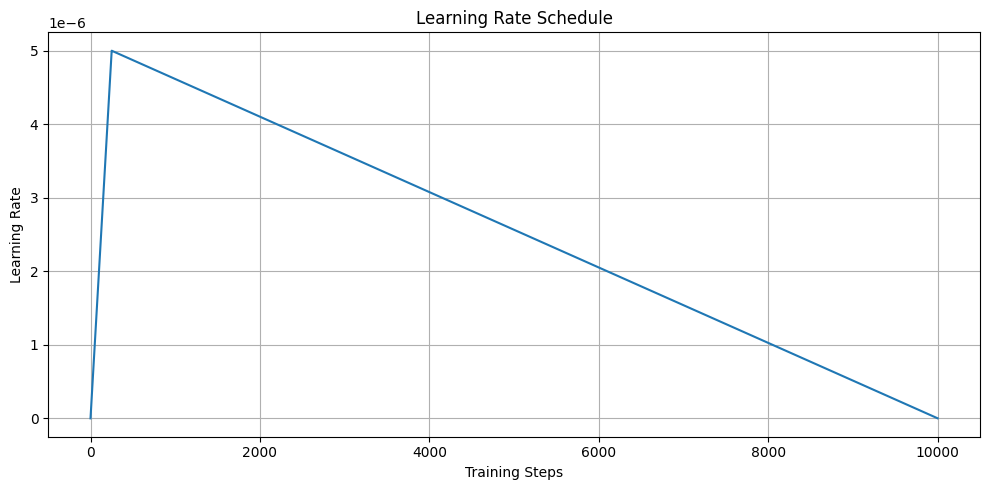

In [10]:
import matplotlib.pyplot as plt
from transformers import create_optimizer

init_lr = 5e-6
num_warmup_steps = 250
num_train_steps = 10000

optimizer, lr_schedule = create_optimizer(
    init_lr=init_lr,
    num_warmup_steps=num_warmup_steps,
    num_train_steps=num_train_steps
)

lrs = [lr_schedule(step).numpy() for step in range(num_train_steps)]

plt.figure(figsize=(10, 5))
plt.plot(range(num_train_steps), lrs)
plt.title("Learning Rate Schedule")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.tight_layout()
plt.show()